In [1]:
from sklearn.model_selection import train_test_split

In [2]:
from collections import Counter

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import nose
import scipy as sp
import keras
%matplotlib inline

Using TensorFlow backend.


In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
import tensorflow as tf

In [8]:
from ast import literal_eval

In [9]:
from preprocess import word_index

In [10]:
def text_to_num(traint):
    count_v = CountVectorizer()
    xt_count = count_v.fit_transform(traint)
    x_new_c = count_v.transform(textt)
    
    return xt_count, x_new_C

In [11]:
train = pd.read_csv('~/data/processed/tok_phase1_train80.csv')
val = pd.read_csv('~/data/processed/tok_phase1_validate10.csv')
test = pd.read_csv('~/data/processed/tok_phase1_test10.csv')

In [12]:
%%time
for frame in [train, val, test]:
    for col in ['summary_tokens', 'review_tokens']:
        frame[col] = frame[col].map(literal_eval)

CPU times: user 38.9 s, sys: 339 ms, total: 39.2 s
Wall time: 39.2 s


In [13]:
from scipy import sparse

def create_one_hot(labels, label_dict):
    """
    Args:
        labels:        array of labels, e.g. NumPy array or Pandas Series
        label_dict:    dict of label indices
    Return:
        one_hot_numpy: sparse CSR 2d array of one-hot vectors
    """
    one_hot_numpy = sparse.dok_matrix((len(labels), len(label_dict)), dtype=np.int8)
    for i, label in enumerate(labels):
        one_hot_numpy[i, label_dict[label]] = 1
    return sparse.csr_matrix(one_hot_numpy) 

def undo_one_hot(pred, label_list):
    """
    
    Args: 
        pred:       NumPy array of one-hot predicted classes
        label_list: a list of the label strings
    Return:
        label_pred: a list of predicted labels
    """
    label_pred = [label_list[np.argmax(row)] for row in pred]
    return label_pred
    # this could probably be done awesomely fast as NumPy vectorised but it works

In [14]:
def create_bow(docs, vocab_map):
    one_hot_numpy = sparse.dok_matrix((len(docs), len(vocab_map)), dtype=np.int8)
    for i, doc in enumerate(docs):
        for _j, token in enumerate(doc):
            if token in vocab_map:
                one_hot_numpy[i, vocab_map[token]] = 1
            
    return sparse.csr_matrix(one_hot_numpy) 

In [15]:
# label set
label_set = set(train['polarity'].unique())

# label list and int map
label_list = sorted(label_set)
label_map = {word: index for index, word in enumerate(label_list)}

In [16]:
### Preprocessing 
# declare the padding and unknown symbols
pad_mask_int = 0
pad_mask_sym = '==pad_mask=='
unknown_int = 1
unknown_sym = '==unknown_sym=='

# vocabulary set
vocab_counter = Counter()
for doc in train['summary_tokens']:
    vocab_counter.update(doc)
for doc in train['review_tokens']:
    vocab_counter.update(doc)    

min_times_word_used = 2 # if at least 2 then the model will be prepared for unknown words in test and validation sets
print(len(vocab_counter), "tokens before discarding those that appear less than {} times.".format(min_times_word_used))
for key in list(vocab_counter.keys()):
    if vocab_counter[key] < min_times_word_used: 
        vocab_counter.pop(key)
print(len(vocab_counter), "tokens after discarding those that appear less than {} times.".format(min_times_word_used))   
vocab_set = set(vocab_counter.keys())

# vocabulary list and int map
vocab_list = [pad_mask_sym, unknown_sym] + sorted(vocab_set)
vocab_map = {word: index for index, word in enumerate(vocab_list)}

185090 tokens before discarding those that appear less than 2 times.
85995 tokens after discarding those that appear less than 2 times.


In [17]:
train_summary = create_bow(train['summary_tokens'], vocab_map)
train_review = create_bow(train['review_tokens'], vocab_map) 

val_summary = create_bow(val['summary_tokens'], vocab_map)
val_review = create_bow(val['review_tokens'], vocab_map) 

test_summary = create_bow(test['summary_tokens'], vocab_map)
test_review = create_bow(test['review_tokens'], vocab_map) 

In [18]:
y_train = create_one_hot(train['polarity'], label_map)
y_val = create_one_hot(val['polarity'], label_map)
y_test = create_one_hot(test['polarity'], label_map)

In [19]:
clf = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial',  max_iter=200)

In [20]:
mm = np.array(y_train[:,0].todense()).ravel()

In [21]:
nn = np.array(y_val[:,0].todense()).ravel()

In [22]:
tt = np.array(y_test[:,0].todense()).ravel()

In [23]:
x_train = train_review
x_val = val_review
x_test = test_review

In [24]:
%%time
clf.fit(x_train, mm)

CPU times: user 49.5 s, sys: 55.9 ms, total: 49.6 s
Wall time: 49.6 s


/home/morten/anaconda3/envs/2nd_proj/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
clf.predict(x_train)

array([1, 1, 1, ..., 1, 0, 0], dtype=int8)

In [26]:
clf.predict_proba(x_train)

array([[1.60752449e-05, 9.99983925e-01],
       [2.41617554e-02, 9.75838245e-01],
       [1.01906215e-03, 9.98980938e-01],
       ...,
       [1.49411550e-01, 8.50588450e-01],
       [6.27885875e-01, 3.72114125e-01],
       [9.45748856e-01, 5.42511437e-02]])

In [27]:
# lbfgs
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',  max_iter=8)
clf.fit(x_train, mm)
lbfgs_train = clf.score(x_train, mm)
print("Training accuracy with LBFGS solver: %s" % lbfgs_train)

Training accuracy with LBFGS solver: 0.8495555555555555


/home/morten/anaconda3/envs/2nd_proj/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [28]:
# lbfgs
lbfgs_val = clf.score(x_val, nn)
print("Validation accuracy with LBFGS solver: %s" % lbfgs_val)

Validation accuracy with LBFGS solver: 0.8408888888888889


In [29]:
lbfgs_test = clf.score(x_test, tt)

In [30]:
# newton-cg
clf = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial',  max_iter=8)
clf.fit(x_train, mm)
ncg_train = clf.score(x_train, mm)
print("Training accuracy with Newton CG solver: %s" % ncg_train)

Training accuracy with Newton CG solver: 0.9859444444444444


/home/morten/anaconda3/envs/2nd_proj/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [31]:
# newton-cg
ncg_val = clf.score(x_val, nn)
print("Validation accuracy with Newton CG solver: %s" % ncg_val)

Validation accuracy with Newton CG solver: 0.8652222222222222


In [32]:
ncg_test = clf.score(x_test, tt)

In [33]:
# sag
clf = LogisticRegression(random_state=7, solver='sag', multi_class='multinomial',  max_iter=8)
clf.fit(x_train, mm)
sag_train = clf.score(x_train, mm)
print("Training accuracy with SAG solver: %s" % sag_train)

Training accuracy with SAG solver: 0.9258194444444444


/home/morten/anaconda3/envs/2nd_proj/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [34]:
# sag
sag_val = clf.score(x_val, nn)
print("Validation accuracy with SAG solver: %s" % sag_val)

Validation accuracy with SAG solver: 0.8806666666666667


In [35]:
clf.predict(x_test)

array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

In [36]:
clf.predict_proba(x_test)

array([[0.99873814, 0.00126186],
       [0.57125379, 0.42874621],
       [0.98426856, 0.01573144],
       ...,
       [0.97110876, 0.02889124],
       [0.01282321, 0.98717679],
       [0.74156466, 0.25843534]])

In [37]:
# sag
sag_test = clf.score(x_test, tt)
print("Test accuracy with SAG solver: %s" % sag_test)

Training accuracy with SAG solver: 0.8794444444444445


In [38]:
import matplotlib.pyplot as plt

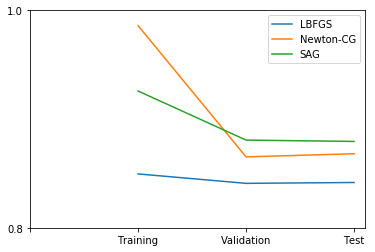

In [39]:
y = [1,2,3]
lbfgs = [lbfgs_train, lbfgs_val, lbfgs_test] 
newton = [ncg_train, ncg_val, ncg_test] 
sag = [sag_train, sag_val, sag_test] 

plt.plot(y, lbfgs)
plt.plot(y, newton)
plt.plot(y, sag)


plt.legend(['LBFGS', 'Newton-CG', 'SAG'], loc='upper right')
plt.xticks(np.arange(4), ('','Training', 'Validation', 'Test'))
plt.yticks([0.8, 1])

plt.show()

In [40]:
len(clf.coef_[0])

85997

In [41]:
len(vocab_map)

85997

In [42]:
import numpy as np
import json

In [43]:
top_idx = np.argmax(clf.coef_[0])
bottom_idx = np.argmin(clf.coef_[0])

In [44]:
vocab_list[top_idx]

'worst'

In [45]:
vocab_list[bottom_idx]

'complaint'

In [46]:
# standardize
out = clf.coef_[0] - np.mean(clf.coef_[0])
out = out / np.std(clf.coef_[0])

In [47]:
sentiment_dic = {vocab_list[idx]: (-1) * out[idx] for idx in range(len(out))}

In [48]:
sentiment_dic['hilarious']

12.723615689363564

In [49]:
sentiment_dic['?']

-5.926091100624023

In [50]:
print(sentiment_dic['waste'], '\n', sentiment_dic['worst'], '\n', sentiment_dic['complaint'], '\n', sentiment_dic['hillarious'])

-21.794588696594992 
 -21.79510801851754 
 15.196817639130069 
 7.11144053760545


In [51]:
sentiment_dic

{'==pad_mask==': 0.0036464657570747794,
 '==unknown_sym==': 0.0036464657570747794,
 '!': 2.8088035895694423,
 '"': -2.402840959331948,
 '#': -4.14208237667819,
 '#1-5': -0.04834126620020309,
 '#10': 0.4038127071370174,
 '#11': 0.21442096219471735,
 '#12': 0.19669568985419889,
 '#14': 0.10329257116145121,
 '#16': 0.8386372714821576,
 '#17': 0.36209447512001536,
 '#19': 0.16227887867091728,
 '#20': 0.02396652206114985,
 '#23': 0.22263009976643183,
 '#24': -0.05709254387941664,
 '#25': 0.004022232823417001,
 '#251': 0.12785844291305828,
 '#26': 0.1661718795842808,
 '#28': 0.017093775227086147,
 '#29': 0.27236362577748074,
 '#30': 0.34250096124784163,
 '#31': 0.34987571681004004,
 '#38': 0.09109851215460012,
 '#audio': 0.09752157456163961,
 '#bd-live': 0.41035516477599904,
 '#bergman': 0.22047209598683332,
 '#commentary': 0.6776207358087157,
 '#deleted': 0.2249223915534695,
 '#disney': 0.07004862865659099,
 '#extras': 0.4135602313262062,
 '#featurette': -0.1505665035446642,
 '#featurettes'

In [52]:
with open('sentiment_dic.json', 'w') as fp:
    json.dump(sentiment_dic, fp)

In [53]:
with open('sentiment_dic.json', 'r') as fp:
    reload = json.load(fp)

In [54]:
reload

{'==pad_mask==': 0.0036464657570747794,
 '==unknown_sym==': 0.0036464657570747794,
 '!': 2.8088035895694423,
 '"': -2.402840959331948,
 '#': -4.14208237667819,
 '#1-5': -0.04834126620020309,
 '#10': 0.4038127071370174,
 '#11': 0.21442096219471735,
 '#12': 0.19669568985419889,
 '#14': 0.10329257116145121,
 '#16': 0.8386372714821576,
 '#17': 0.36209447512001536,
 '#19': 0.16227887867091728,
 '#20': 0.02396652206114985,
 '#23': 0.22263009976643183,
 '#24': -0.05709254387941664,
 '#25': 0.004022232823417001,
 '#251': 0.12785844291305828,
 '#26': 0.1661718795842808,
 '#28': 0.017093775227086147,
 '#29': 0.27236362577748074,
 '#30': 0.34250096124784163,
 '#31': 0.34987571681004004,
 '#38': 0.09109851215460012,
 '#audio': 0.09752157456163961,
 '#bd-live': 0.41035516477599904,
 '#bergman': 0.22047209598683332,
 '#commentary': 0.6776207358087157,
 '#deleted': 0.2249223915534695,
 '#disney': 0.07004862865659099,
 '#extras': 0.4135602313262062,
 '#featurette': -0.1505665035446642,
 '#featurettes'

In [55]:
np.std(list(reload.values()))

1.0

(array([6.0000e+00, 1.1000e+01, 3.7000e+01, 8.7000e+01, 6.1200e+02,
        7.0922e+04, 1.3940e+04, 3.1900e+02, 5.4000e+01, 9.0000e+00]),
 array([-21.79510802, -18.09591545, -14.39672289, -10.69753032,
         -6.99833776,  -3.29914519,   0.40004738,   4.09923994,
          7.79843251,  11.49762507,  15.19681764]),
 <a list of 10 Patch objects>)

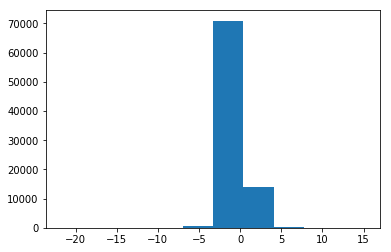

In [56]:
plt.hist(list(reload.values()))

In [57]:
for key, value in reload.items():
    if value > 8.5:
        print('', round(value, 1), key)
    elif value < -8.5:
        print(round(value, 1), key)
    else:
        pass

 2.8 !
-4.1 #
-2.9 $
-2.8 );
-3.1 *
 4.3 +
-3.6 . ...
-3.7 0
 4.9 000
-4.9 1/2
 4.2 10/10
 3.6 1080p
 2.8 12
 2.6 13th
-3.1 180
 2.9 19
 3.8 1930
 3.3 1933
 3.5 1940s
-2.8 1959
-3.2 1979
-3.7 1981
 3.5 1988
-4.4 2
-2.6 2/5
-4.0 2007
 2.9 2009
-2.6 21st
 2.8 38
-3.2 3d
 4.6 4
-2.6 44
-3.7 48
 4.6 5
-3.4 60s
-2.6 67
 3.0 7/10
-3.1 70
-3.0 75
 2.7 8/
 5.3 9/10
 2.5 90s
-3.1 98
-3.4 :(
 6.4 :)
 4.4 :-)
-5.9 ?
 4.2 _
-4.2 `
-2.8 abc
 3.3 able
-2.9 abominable
-3.5 abomination
 5.3 above
-2.8 abrupt
 3.5 abruptly
 4.4 absolute
 3.4 absorbing
-2.6 abstract
-3.7 absurd
-7.3 abysmal
-2.5 acceptable
 3.8 accepted
-3.6 access
 3.6 accident
 5.3 accidentally
 2.6 acclaimed
-4.6 according
-3.1 account
 2.7 accuracy
 3.6 accused
 5.6 achieved
 2.8 achievement
-3.4 act
 4.5 acted
 4.2 action
 3.6 action-packed
-2.7 acts
-3.2 adaption
 3.0 add
 3.2 added
 2.7 addicted
 3.1 addictive
 3.3 addition
 6.2 additional
 7.7 adds
-4.7 adequate
-4.0 admirable
 4.0 admirably
-2.6 admittedly
 5.1 adorable
-4.3 ad

 2.7 golf
 5.6 goofy
 2.7 gore
 4.2 gorgeous
 2.5 goriest
 8.4 gothic
 5.0 gotten
 4.1 government
 6.1 gradually
 3.6 graham
-4.2 grainy
 4.9 grand
-3.6 grandfather
-5.0 grating
-3.3 gray
 9.8 great
 5.4 greatest
-4.6 greatly
 2.8 greats
 3.3 grey
 3.6 gripe
 3.2 gripping
 5.4 gritty
-3.6 gross
-4.5 grossly
-3.4 grotesque
 2.8 grow
 3.5 growing
-2.5 gruesome
 2.9 guaranteed
-5.8 guess
-2.7 guessed
 5.2 guessing
 3.5 guide
 3.9 guitar
-3.1 gump
-3.1 h
-3.9 hack
-3.9 hackneyed
-5.1 half
-4.2 halfway
 2.6 hammer
-6.2 hammy
 3.5 handled
-2.5 hanks
 3.9 happily
 3.0 happiness
 4.1 happy
-7.8 hardly
-2.5 harmon
 4.4 harold
 4.4 harrowing
-3.0 hartnett
 4.4 harvey
-7.5 hated
 4.0 hayden
-3.0 headache
 2.9 health
-3.6 heap
 3.3 heart
 3.6 hearted
 3.7 heartfelt
 2.7 heather
-3.3 heavily
-3.1 heavy-handed
 2.9 heck
 3.2 heels
 3.3 helen
 2.8 helping
 3.3 helps
 3.2 hepburn
 3.0 herself
 3.4 heterosexual
-2.7 hewitt
-4.3 hideous
 3.1 hiding
-2.9 higher
 3.5 highest
-2.9 highlander
 3.7 highlight

 7.3 spectacular
-2.9 speeding
 3.3 spellbinding
-3.3 spending
-3.7 spends
-6.1 spent
 3.0 spike
 2.9 spirit
 3.8 spite
 3.1 splatter
 4.3 splendid
 2.7 split
 6.2 spoil
-4.6 spoiled
 4.8 spooky
 3.4 spurlock
-3.6 squandered
 3.2 squeamish
 3.3 st
-6.4 stale
-3.4 stamp
 3.7 stands
-4.5 star
-2.6 star-crossed
-4.2 starring
 2.9 startling
 4.4 states
-4.8 stay
-2.6 staying
 2.7 stays
 4.2 steal
 3.5 steals
 3.3 steel
-5.2 steer
 5.9 stellar
-2.7 stereotype
-3.6 steven
-12.1 stick
-4.0 sticking
-4.2 stiff
 6.2 still
-2.8 stills
-5.1 stilted
-7.7 stinker
-13.8 stinks
-4.3 stock
-2.6 stoner
 3.8 stopping
 3.1 stops
-2.8 strain
 4.9 strangely
-3.1 straw
 3.8 streets
 6.1 strength
-3.9 strictly
 3.0 striking
-2.6 stripper
 2.9 strong
 5.2 struck
 3.3 structure
-3.1 studio
 2.9 stumbled
-6.0 stunk
 3.6 stunned
 4.1 stunning
-3.0 stunts
-12.3 stupid
-5.2 stupidest
-5.4 stupidity
-2.8 sub-par
-2.9 subjects
-3.4 subpar
-4.9 subsequent
 4.4 subsequently
-9.9 substance
-3.9 substandard
 5.5 subtitl

In [144]:
for key, value in reload.items():
    if value > 8.5:
        print('', round(value, 1), key)
    else:
        pass

 9.0 amazing
 14.8 awesome
 9.0 beautifully
 9.0 brilliant
 9.6 brilliantly
 11.3 complain
 15.2 complaint
 9.5 critics
 9.3 definately
 10.3 enjoyable
 12.8 enjoyed
 12.8 excellent
 8.9 expressions
 11.1 fantastic
 9.6 favorites
 8.6 finest
 9.1 fun
 14.0 funniest
 10.9 gem
 10.1 glad
 9.8 great
 8.7 highly
 12.7 hilarious
 8.7 incredible
 10.9 intense
 8.9 loved
 9.3 must-see
 8.7 notch
 11.6 outstanding
 14.9 perfect
 10.0 pleasantly
 8.8 pleased
 8.7 powerful
 9.4 recommended
 10.1 refreshing
 8.7 shines
 8.7 smart
 9.4 solid
 14.5 superb
 8.8 surprised
 8.6 terrific
 8.6 treat
 8.5 unforgettable
 9.1 unique
 9.2 viewings
 9.6 wonderful
 10.0 wonderfully


In [145]:
for key, value in reload.items():
    if value < -8.5:
        print(round(value, 1), key)
    else:
        pass

-9.8 annoying
-11.0 asleep
-13.0 avoid
-16.1 awful
-8.9 bad
-9.5 badly
-8.5 barely
-13.1 bland
-8.5 bore
-11.1 bored
-19.2 boring
-8.8 contrived
-20.4 disappointing
-19.8 disappointment
-8.7 dissapointed
-10.7 downhill
-8.9 dragged
-10.3 dreadful
-17.2 dull
-10.7 empty
-10.0 excited
-16.5 fails
-10.1 favor
-14.4 flat
-14.3 forgettable
-16.4 garbage
-8.6 hopes
-9.4 hoping
-11.4 horrible
-9.0 instead
-11.0 insult
-9.9 joke
-11.7 junk
-13.9 lacks
-14.2 lame
-12.8 laughable
-12.6 lousy
-17.5 mediocre
-15.6 mess
-14.1 mildly
-10.9 miscast
-9.3 nothing
-14.7 overrated
-9.5 pass
-11.5 pathetic
-10.3 pointless
-12.1 poor
-17.8 poorly
-9.1 positive
-12.6 potential
-12.6 predictable
-11.3 promising
-10.1 propaganda
-14.7 redeeming
-11.5 ridiculous
-9.5 rip-off
-11.2 ruined
-9.8 save
-8.9 shallow
-15.2 skip
-10.6 sorry
-12.1 stick
-13.8 stinks
-12.3 stupid
-9.9 substance
-9.6 sucks
-10.4 suffers
-9.7 supposed
-13.2 tedious
-15.8 terrible
-8.8 trash
-8.7 travesty
-11.3 turkey
-9.6 unconvincing
-13

In [60]:
np.zeros(5).shape

(5,)

In [62]:
np.array([5]).shape

(1,)

In [122]:
from spellchecker import SpellChecker

spell = SpellChecker(language=None)  # turn off loading a built language dictionary

# if you have a dictionary...
#spell.word_frequency.load_dictionary('./path-to-my-json-dictionary.json')

# or... if you have text
spell.word_frequency.load_text_file('../../../../data/external/glove.42B.words.len_over_5.txt')
#spell.distance = 1
# export it out for later use!
#spell.export('my_custom_dictionary.gz', gzipped=True)

In [123]:
spell.unknown(['zzzzits'])

{'zzzzits'}

In [113]:
! head ../../../../data/external/glove.42B.words.txt

,
the
.
and
to
of
a
in
"
is


In [118]:
spell.candidates('hillrious')

{'hilarious', 'hilerious', 'hillarious', 'hilrious'}

In [114]:
spell.word_frequency.dictionary['zzzits']

0

In [115]:
spell.word_frequency.total_words

2526311

In [116]:
spell.export('custom_spell.json', gzipped=False)

In [117]:
spell = SpellChecker(language=None, local_dictionary='custom_spell.json')


In [119]:
spell.word_frequency.dictionary['zzzits']

0

In [130]:
import re
import contractions as con
from spellchecker import SpellChecker
from nltk import TweetTokenizer

def make_spellchecker():
    """
    Initialise spellchecker object with a dictionary based on the words in the pre-trained embeddings
    """
    spell = SpellChecker(language=None, local_dictionary='../../../../data/external/custom_spell.json')
    spell.word_frequency.add("_possessivetag_")
    return spell 

def make_tokenizer():
    """
    Initialise spellchecker object with a dictionary based on the words in the pre-trained embeddings
    """
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    return tokenizer 

def tokenize1(string, spellcheck, tokenizer, spell):
    """
    takes string input and tokenizes into a list of strings. 
    #runningtime is 0(n)*6

    Examples
    >>> tokenize1('MC Hammer (He is credited as Hammer) portrays a druglord...so you do a math. Bruce Payne', False, make_tokenizer(), make_spellchecker())
    ['mc', 'hammer', '(', 'he', 'is', 'credited', 'as', 'hammer', ')', 'portrays', 'a', 'druglord', '...', 'so', 'you', 'do', 'a', 'math', '.', 'bruce', 'payne']
    >>> tokenize1('I am soooooo baaaad!!!!')
    ['i', 'am', 'sooo', 'baaad', '!', '!', '!']
    >>> tokenize1('diller/vagene')
    ['diller', '/', 'vagene']
    >>> tokenize1('what now..little boy.....')
    ['what', 'now', '...', 'little', 'boy', '...']
    >>> tokenize1("Film's have 'Act Two' which sucks.")
    ['film', "'s", 'have', "'", 'act', 'two', "'", 'which', 'sucks', '.']
    """

    string = re.sub('\&quot;', '', string)
    string = re.sub("\'s ", " _possessivetag_ " , string)
    string = re.sub('(?<=[.,])(?=[^\W])', ' ' , string)
    string = re.sub("\--", ' -- ' , string)
    #string = re.sub('(?P<rep>.)(?P=rep){3,}', '\g<rep>\g<rep>\g<rep>', string)
    string = re.sub("\d+|\+"," \g<0> ", string)
    
    string = con.fix(string)

    tokens = tokenizer.tokenize(string)


    if spellcheck == True:
        # find those words that may be misspelled
        misspelled = spell.unknown(tokens)
        if len(misspelled)!= 0: 
            for i, token in enumerate(tokens):
                if token in misspelled and len(token) > 5:
                    correction = spell.correction(token)
                    #print(token + " converts to: " + correction)
                    tokens[i] = correction
    
    for i, token in enumerate(tokens):
        if token == "_possessivetag_":
            tokens[i] = "'s" 

    return tokens


In [134]:
tokenize1('MC Hammer (He is credited as Hammer) porrrays a druglord...so you do a math. Bruce Payne', True, make_tokenizer(), make_spellchecker())

['mc',
 'hammer',
 '(',
 'he',
 'is',
 'credited',
 'as',
 'hammer',
 ')',
 'portrays',
 'a',
 'druglord',
 '...',
 'so',
 'you',
 'do',
 'a',
 'math',
 '.',
 'bruce',
 'payne']

In [142]:
review = "Bevare! Bevare! Dracula is suspect here!"

In [143]:
for pair in zip(tokenize1(review, False, make_tokenizer(), make_spellchecker()), tokenize1(review, True, make_tokenizer(), make_spellchecker())):
    print(pair)

('bevare', 'beware')
('!', '!')
('bevare', 'beware')
('!', '!')
('dracula', 'dracula')
('is', 'is')
('suspect', 'suspect')
('here', 'here')
('!', '!')
